# 環境確認

In [ ]:
import sys
import torch

print("Pythonのバージョン：",sys.version)
print("PyTorchのバージョン：", torch.__version__)
print("使用しているGPUの確認")
!nvidia-smi

Pythonのバージョン： 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
PyTorchのバージョン： 1.10.0+cu111
使用しているGPUの確認
Fri Feb 18 05:43:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----

# データのダウンロード

In [ ]:
# Fruits-360 dataset をダウンロードし、解凍する

!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/rp73yg93n8-1.zip -nc -P ./data/
!unzip -n ./data/rp73yg93n8-1.zip -d ./data/
!unzip -n -q ./data/fruits-360_dataset.zip -d ./data/

File ‘./data/rp73yg93n8-1.zip’ already there; not retrieving.

Archive:  ./data/rp73yg93n8-1.zip


# 事前準備

In [ ]:
import os
import random
from glob import glob
from warnings import filterwarnings

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.init as init
from natsort import natsorted
from PIL import Image
from skimage import io, transform
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from torchsummary import summary

filterwarnings("ignore")  # warningをオフにする

# ランダムシードの設定
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
'''初期設定'''

COLAB_FLG = False  # COLABで実行する場合はTrue, それ以外で実行する場合はFalse

if COLAB_FLG:
    from google.colab import drive
    drive.mount('/content/gdrive') # マウント先
    ATTACH_PATH = "/content/gdrive/MyDrive/Colab Notebooks/EfficientGAN-RGB"  # 保存先のベースディレクトリ
else:
    ATTACH_PATH = "."  # ローカルならカレントディレクトリ
    
    
SAVE_MODEL_PATH = f"{ATTACH_PATH}/results/EfficientGAN/model/"  # モデルの保存先
SAVE_IMAGE_FROM_Z_PATH = f"{ATTACH_PATH}/results/EfficientGAN/image/image_from_z/"  # 乱数から生成した画像の保存先
SAVE_IMAGE_RECONSTRUCT = f"{ATTACH_PATH}/results/EfficientGAN/image/RECONSTRUCT/"  # 再構成した画像の保存先

# 保存先のディレクトリを作成する
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_FROM_Z_PATH, exist_ok=True)
os.makedirs(SAVE_IMAGE_RECONSTRUCT, exist_ok=True)

In [ ]:
'''ハイパーパラメータの設定'''

import argparse

parser = argparse.ArgumentParser()
parser.add_argument("--image_size", type=int, default=96)
parser.add_argument("--num_epochs", type=int, default=1000)
parser.add_argument("--batch_size", type=int, default=16)
parser.add_argument("--lr", type=float, default=4e-4)
parser.add_argument("--z_dim", type=int, default=128) # ノイズの次元
parser.add_argument("--beta1", type=float, default=0.5) # Adamのハイパーパラメータ
parser.add_argument("--beta2", type=float, default=0.999) # Adamのハイパーパラメータ
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=16, beta1=0.5, beta2=0.999, image_size=96, lr=0.0004, num_epochs=1000, z_dim=128)


In [ ]:
# デバイスの設定
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {} # GPUが使える場合、DataLoaderでのミニバッチの取り出しを高速化

# DataLoader

In [ ]:
train_root = './data/fruits-360/Training/Physalis/'  # train dataの保存してあるディレクトリ
val_root = './data/fruits-360/Test/Physalis/'  # val dataの保存してあるディレクトリ

In [ ]:
# ディレクトリから画像を読み込んでDataLoaderに渡す用のクラス

class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = natsorted(os.listdir(main_dir)) # ディレクトリ一覧を取得して自然ソート
        self.all_imgs_name = natsorted(all_imgs)
        self.imgs_loc = [os.path.join(self.main_dir, i) for i in self.all_imgs_name] # 画像のディレクトリ一覧

    def __len__(self):
        return len(self.all_imgs_name)
    
    def load_image(self, path):
        image = Image.open(path).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image
    
    def __getitem__(self, idx):
        
        # 後ほどsliceで画像を複数枚取得したいのでsliceでも取れるようにする
        if type(idx) == slice:
            paths = self.imgs_loc[idx]
            tensor_image = [self.load_image(path) for path in paths]
            tensor_image = torch.cat(tensor_image).reshape(len(tensor_image), *tensor_image[0].shape)
        elif type(idx) == int:
            path = self.imgs_loc[idx]
            tensor_image = self.load_image(path)
        return tensor_image

In [ ]:
# 画像を読み込む際の前処理

transform_dict = {
    "train": transforms.Compose(
        [
            transforms.Resize((opt.image_size, opt.image_size)),  # image_sizeにreshape
            transforms.RandomHorizontalFlip(), # ランダムに左右反転を行う
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,))
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize((opt.image_size, opt.image_size)),  # image_sizeにreshape
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,))
        ]
    ),
}

In [ ]:
# データを読み込む
train_dataset = LoadFromFolder(train_root, transform=transform_dict["train"])

test_dataset = LoadFromFolder(val_root, transform=transform_dict["test"])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = opt.batch_size, shuffle=True, **kwargs)

val_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = opt.batch_size, shuffle=True, **kwargs)

# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False), # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False), # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(256, 512, kernel_size=6, stride=1, bias=False), # 1x1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),  
            
            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False), # 1x1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),  
        )

        self.last = nn.Sequential(nn.Conv2d(512, opt.z_dim, kernel_size=1, stride=1, bias=False))

    def forward(self, x):

        out = self.main(x)
        out = self.last(out)
        out = out.view(out.size()[0], -1, 1, 1)
        return out

In [ ]:
# ネットワークを可視化する

summary(Encoder().to(device), (3, opt.image_size, opt.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,536
       BatchNorm2d-2           [-1, 32, 48, 48]              64
         LeakyReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]          32,768
       BatchNorm2d-5           [-1, 64, 24, 24]             128
         LeakyReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 12, 12]         131,072
       BatchNorm2d-8          [-1, 128, 12, 12]             256
         LeakyReLU-9          [-1, 128, 12, 12]               0
           Conv2d-10            [-1, 256, 6, 6]         524,288
      BatchNorm2d-11            [-1, 256, 6, 6]             512
        LeakyReLU-12            [-1, 256, 6, 6]               0
           Conv2d-13            [-1, 512, 1, 1]       4,718,592
      BatchNorm2d-14            [-1, 51

# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(opt.z_dim, 256, kernel_size=6, stride=1, padding=0, bias=False),  # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),  # 48x48
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),  # 96x96
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.main(z)
        return out

In [ ]:
# ネットワークを可視化する

summary(Generator().to(device), tuple([opt.z_dim, 1, 1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 6, 6]       1,179,648
       BatchNorm2d-2            [-1, 256, 6, 6]             512
         LeakyReLU-3            [-1, 256, 6, 6]               0
   ConvTranspose2d-4          [-1, 128, 12, 12]         524,288
       BatchNorm2d-5          [-1, 128, 12, 12]             256
         LeakyReLU-6          [-1, 128, 12, 12]               0
   ConvTranspose2d-7           [-1, 64, 24, 24]         131,072
       BatchNorm2d-8           [-1, 64, 24, 24]             128
         LeakyReLU-9           [-1, 64, 24, 24]               0
  ConvTranspose2d-10           [-1, 32, 48, 48]          32,768
      BatchNorm2d-11           [-1, 32, 48, 48]              64
        LeakyReLU-12           [-1, 32, 48, 48]               0
  ConvTranspose2d-13            [-1, 3, 96, 96]           1,536
             Tanh-14            [-1, 3,

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.x_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 48x48
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 24x24
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 12x12
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 6x6
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 256, kernel_size=6, stride=1),  # 1x1
        )
        self.z_layer = nn.Sequential(
            nn.Conv2d(opt.z_dim, 256, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout2d(p=0.2),
        )

        self.last1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1),
            nn.LeakyReLU(0.1, inplace=False),
            nn.Dropout2d(p=0.2),
        )
        self.last2 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size=1, stride=1),
        )

    def forward(self, x, z):

        output_x = self.x_layer(x)
        output_z = self.z_layer(z)

        concat_x_z = torch.cat((output_x, output_z), 1)
        output = self.last1(concat_x_z)

        feature = output.view(output.size()[0], -1)

        output = self.last2(output)
        output = F.sigmoid(output)
        return output.squeeze(), feature

In [ ]:
# ネットワークを可視化する

summary(Discriminator().to(device), [(3, opt.image_size, opt.image_size), (opt.z_dim, 1, 1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,568
         LeakyReLU-2           [-1, 32, 48, 48]               0
         Dropout2d-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]          32,832
       BatchNorm2d-5           [-1, 64, 24, 24]             128
         LeakyReLU-6           [-1, 64, 24, 24]               0
         Dropout2d-7           [-1, 64, 24, 24]               0
            Conv2d-8          [-1, 128, 12, 12]         131,200
       BatchNorm2d-9          [-1, 128, 12, 12]             256
        LeakyReLU-10          [-1, 128, 12, 12]               0
        Dropout2d-11          [-1, 128, 12, 12]               0
           Conv2d-12            [-1, 256, 6, 6]         524,544
      BatchNorm2d-13            [-1, 256, 6, 6]             512
        LeakyReLU-14            [-1, 25

In [ ]:
# 重みの初期化を行う関数

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
E = Encoder().to(device)
E.apply(weights_init)

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator().to(device)
D.apply(weights_init)

criterion = nn.BCELoss()  # 評価関数
criterion_L1 = nn.L1Loss(reduction="sum") # 異常スコア計測用

# gとeは共通のoptimizer
optimizer_ge = torch.optim.Adam(list(G.parameters()) + list(E.parameters()), lr=opt.lr, betas=(0.5,0.999))
optimizer_d = torch.optim.Adam(D.parameters(), lr=opt.lr, betas=(0.5,0.999))

scheduler_ge = torch.optim.lr_scheduler.StepLR(optimizer_ge, step_size=50, gamma=0.9)
scheduler_d = torch.optim.lr_scheduler.StepLR(optimizer_d, step_size=50, gamma=0.9)

# 学習

In [ ]:
def Anomaly_score(x, E_x, G_E_x, Lambda=0.1):
    
    _,x_feature = D(x, E_x)
    _,G_E_x_feature = D(G_E_x, E_x)
    
    residual_loss = criterion_L1(x, G_E_x)
    discrimination_loss = criterion_L1(x_feature, G_E_x_feature)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = total_loss.item()

    return total_loss

In [ ]:
Losses_D = []
Losses_GE = []
anomaly_scores = []


for epoch in range(opt.num_epochs):
    loss_d_sum = 0
    loss_ge_sum = 0
    anomaly_score_sum = 0
    
    for i,(x, x_val) in enumerate(zip(train_loader, val_loader)):
        
        G.train()
        D.train()
        E.train()

        # 値の設定
        y_true = Variable(torch.ones(x.size()[0])).to(device)
        y_fake = Variable(torch.zeros(x.size()[0])).to(device)
        
        x = Variable(x).to(device)
        z = Variable(init.normal(torch.Tensor(x.size()[0],opt.z_dim, 1, 1),mean=0,std=0.1)).to(device)
        
        # Discriminatorに対するノイズ
        noise1 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (opt.num_epochs - epoch) / opt.num_epochs),
                          requires_grad=False).to(device)
        noise2 = Variable(torch.Tensor(x.size()).normal_(0, 0.1 * (opt.num_epochs - epoch) / opt.num_epochs),
                          requires_grad=False).to(device)

        # Discriminator
        optimizer_d.zero_grad()
        
        E_x = E(x) 
        p_true, _ = D(x + noise1, E_x)
        
        G_z = G(z)
        p_fake, _ = D(G_z + noise2, z)
        
        loss_d = criterion(p_true, y_true) + criterion(p_fake, y_fake)
        loss_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # Generator, Encoder
        optimizer_ge.zero_grad()
        
        p_true, _ = D(x + noise1, E_x)
        p_fake, _ = D(G_z + noise2, z)
        
        loss_ge = criterion(p_fake, y_true) + criterion(p_true, y_fake)
        loss_ge.backward(retain_graph=True)
        optimizer_ge.step()
        
        loss_d_sum += loss_d.item()
        loss_ge_sum += loss_ge.item()
        
        # anomaly scoreの記録
        
        G.eval()
        D.eval()
        E.eval()
        x_val = Variable(x_val).to(device)
        E_x_val = E(x_val)
        G_E_x_val = G(E_x_val)
        anomaly_score_sum += Anomaly_score(x_val, E_x_val, G_E_x_val)
            
        # 画像を保存
        if i == 0:
        
            save_image_size_for_z = min(opt.batch_size, 8)
            save_images = G(z)
            save_image(save_images[:save_image_size_for_z], f"{SAVE_IMAGE_FROM_Z_PATH}/epoch_{epoch}.png", nrow=4)

            save_image_size_for_recon = min(opt.batch_size, 8)
            images = x[:save_image_size_for_recon]
            G_E_x = G(E(images))
            diff_images = torch.abs(images - G_E_x)
            comparison = torch.cat([images , G_E_x, diff_images]).to("cpu")
            save_image(comparison, f"{SAVE_IMAGE_RECONSTRUCT}/epoch_{epoch}.png", nrow=save_image_size_for_recon)
            
    scheduler_ge.step()
    scheduler_d.step()
        
    # lossを記録
    loss_d_mean = loss_d_sum / len(train_loader)
    loss_ge_mean = loss_ge_sum / len(train_loader)
    anomaly_score_mean = anomaly_score_sum / len(train_loader)
    
    print(f"{epoch}/{opt.num_epochs} epoch ge_loss: {loss_ge_mean:.3f} d_loss: {loss_d_mean:.3f} anomaly_score: {anomaly_score_mean:.3f}")
    
    Losses_D.append(loss_d_mean)
    Losses_GE.append(loss_ge_mean)
    anomaly_scores.append(anomaly_score_mean)
    
    # モデルを保存
    if (epoch + 1) % 10 == 0:
        torch.save(G.state_dict(),f'{SAVE_MODEL_PATH}/Generator_{epoch + 1}.pkl')
        torch.save(E.state_dict(),f'{SAVE_MODEL_PATH}/Encoder_{epoch + 1}.pkl')
        torch.save(D.state_dict(),f'{SAVE_MODEL_PATH}/Discriminator_{epoch + 1}.pkl')

0/1000 epoch ge_loss: 2.857 d_loss: 0.167 anomaly_score: 86992.985
1/1000 epoch ge_loss: 6.325 d_loss: 0.071 anomaly_score: 87308.591
2/1000 epoch ge_loss: 4.827 d_loss: 0.153 anomaly_score: 88185.352
3/1000 epoch ge_loss: 4.030 d_loss: 0.110 anomaly_score: 83623.498
4/1000 epoch ge_loss: 3.204 d_loss: 0.398 anomaly_score: 73067.714
5/1000 epoch ge_loss: 1.541 d_loss: 0.275 anomaly_score: 54661.160
6/1000 epoch ge_loss: 1.961 d_loss: 0.292 anomaly_score: 45891.197
7/1000 epoch ge_loss: 1.976 d_loss: 0.297 anomaly_score: 45415.988
8/1000 epoch ge_loss: 1.586 d_loss: 0.260 anomaly_score: 50963.621
9/1000 epoch ge_loss: 1.592 d_loss: 0.342 anomaly_score: 43181.784
10/1000 epoch ge_loss: 1.385 d_loss: 0.384 anomaly_score: 46003.389
11/1000 epoch ge_loss: 1.388 d_loss: 0.342 anomaly_score: 48561.266
12/1000 epoch ge_loss: 1.578 d_loss: 0.279 anomaly_score: 47970.479
13/1000 epoch ge_loss: 1.587 d_loss: 0.208 anomaly_score: 46327.208
14/1000 epoch ge_loss: 1.428 d_loss: 0.310 anomaly_score: 

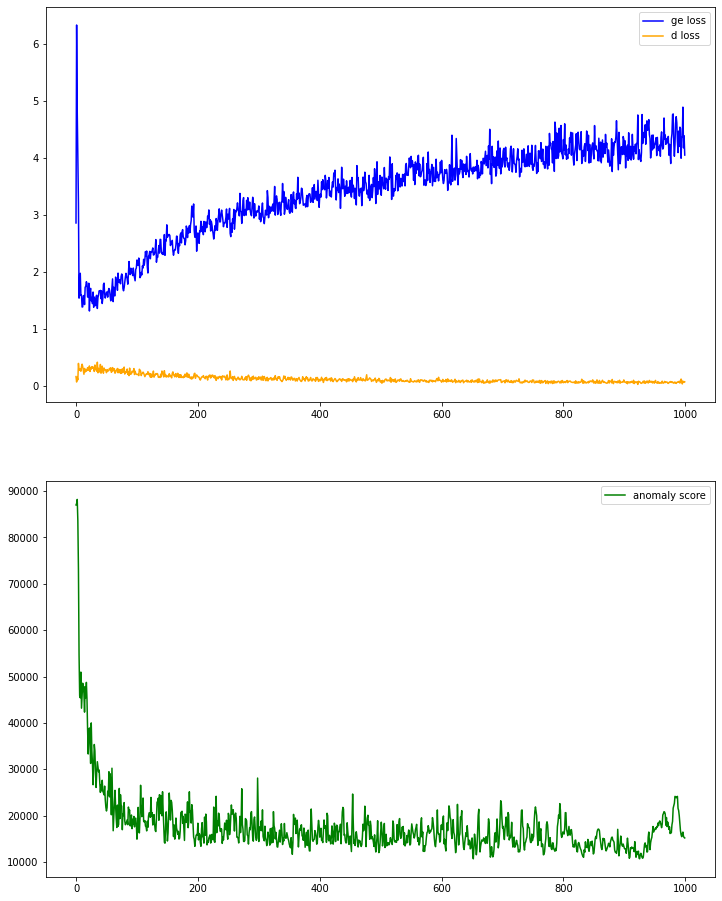

In [ ]:
# Generator+EncoderとDiscriminatorのLossの推移と、anomaly scoreの推移
plt.figure(figsize=(12, 8*2))

plt.subplot(211)
plt.plot(range(len(Losses_GE)), Losses_GE, label="ge loss",color="blue")
plt.legend()

plt.plot(range(len(Losses_D)), Losses_D, label="d loss",color="orange")
plt.legend()
plt.subplot(212)
plt.plot(range(len(anomaly_scores)), anomaly_scores, label="anomaly score",color="green")
plt.legend()

plt.show()

# 潜在変数Zの最適化とテスト画像での異常検知

In [ ]:
# 学習したモデルの読み込み

LOAD_EPOCH = 1000

G = Generator().to(device)
G.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Generator_{LOAD_EPOCH}.pkl"))
G.eval()


E = Encoder().to(device)
E.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Encoder_{LOAD_EPOCH}.pkl"))
E.eval()

D = Discriminator().to(device)
D.load_state_dict(torch.load(f"{SAVE_MODEL_PATH}/Discriminator_{LOAD_EPOCH}.pkl"))
D.eval()
print("load model")

load model


In [ ]:
# 正常な画像で実行

random_image_size = 100

test_root_normal = './data/fruits-360/Test/Physalis/'
test_dataset_normal = LoadFromFolder(test_root_normal, transform=transform_dict["test"])

test_images_normal = random.sample(list(test_dataset_normal), random_image_size)

normal_anomaly_score = []

# うまく再現され、異常スコアが低くなっていれば成功
for idx in range(len(test_images_normal)):

    x = test_images_normal[idx].view(1, 3, 96, 96).to(device)
    E_x = E(x)
    G_E_x = G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    normal_anomaly_score.append(loss)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()

In [ ]:
# 画像に傷を模した記号を付与する関数

def add_damage(image_path):
    
    folder = os.path.dirname(image_path)
    save_folder = folder + "_damaged"
    save_base_path = os.path.basename(image_path).replace(".jpg", "_damaged.jpg")
    save_path = os.path.join(save_folder, save_base_path)
    
    os.makedirs(save_folder, exist_ok=True)
    
    image = cv2.imread(image_path)
    center_x = random.randint(20, 76)
    center_y = random.randint(20, 76)
    color_r = random.randint(0, 255)
    color_g = random.randint(0, 255)
    color_b = random.randint(0, 255)
    
    center = (center_x, center_y)
    color = (color_r, color_g, color_b)
    
    cv2.circle(image, center = center, radius = 10, color = color,thickness=-1)
    cv2.imwrite(save_path, image)
    
images_path = glob('./data/fruits-360/Test/Physalis/*.jpg')
[add_damage(image_path) for image_path in images_path]
print("add damage")

add damage


In [ ]:
# 異常な画像で実行

test_root_anomaly = './data/fruits-360/Test/Physalis_damaged/'
test_dataset_anomaly = LoadFromFolder(test_root_anomaly, transform=transform_dict["test"])

test_images_anomaly = random.sample(list(test_dataset_anomaly), random_image_size)

scratch_anomaly_score = []

# うまく再現されず、異常スコアが高くなっていれば成功
for idx in range(len(test_images_anomaly)):

    x = test_images_anomaly[idx].view(1, 3, 96, 96).to(device)
    E_x = E(x)
    G_E_x = G(E_x)
    
    loss = Anomaly_score(x, E_x, G_E_x)
    scratch_anomaly_score.append(loss)
    diff_img = torch.abs(x - G_E_x)
    print(f"Anomaly_score: {loss:.3f}")
    comparison = torch.cat([x.to("cpu"), G_E_x.to("cpu"), diff_img.to("cpu")])
    joined_image = make_grid(comparison, nrow=3).detach().numpy()
    joined_image = np.transpose(joined_image, [1, 2, 0])
    
    plt.figure(figsize=(12, 4))
    plt.imshow((joined_image * 255).astype(np.uint8))
    plt.show()

In [ ]:
# 正常品のスコアをデータフレーム化
normal_df = pd.DataFrame({'score': normal_anomaly_score})
normal_df['label'] = 'normal'

# 傷品のスコアをデータフレーム化
scratch_df = pd.DataFrame({'score': scratch_anomaly_score})
scratch_df['label'] = 'scratch'

# 正常品と傷品のデータフレームを結合
test_df = pd.concat([normal_df, scratch_df]).reset_index()

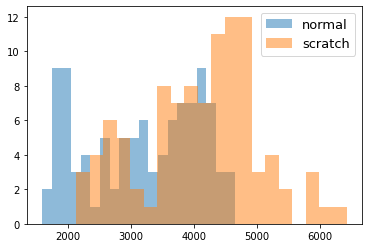

In [ ]:
#テストデータのlossを可視化

plt.hist(normal_df['score'], alpha=0.5, bins=20, label='normal')
plt.hist(scratch_df['score'], alpha=0.5, bins=20, label='scratch')
plt.legend(loc="upper right", fontsize=13)
plt.show()